In [ ]:
!nvidia-smi

Fri Nov  7 02:44:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q albumentations opencv-python scikit-image tqdm matplotlib

In [ ]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:
class SkinDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        img = np.transpose(img, (2,0,1)).astype(np.float32)/255.0
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)/255.0
        return torch.tensor(img), torch.tensor(mask)

In [ ]:
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
!unzip -q ISIC2018_Task1-2_Training_Input.zip -d /content/data/images/
!unzip -q ISIC2018_Task1_Training_GroundTruth.zip -d /content/data/masks/

In [ ]:
# Cell 1 — quick environment check + counts
import os, shutil
from glob import glob
print("cwd:", os.getcwd())

imgs = sorted(glob("/content/data/images/*"))
masks = sorted(glob("/content/data/masks/*"))
print("Images found:", len(imgs))
print("Masks found:", len(masks))

# disk usage (human readable)
!df -h /content

cwd: /content
Images found: 1
Masks found: 2
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   61G   53G  54% /


In [ ]:
import albumentations as A
transform_train = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5)
])
transform_val = A.Compose([A.Resize(256,256)])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = ConvBlock(3,64)
        self.p1 = nn.MaxPool2d(2)
        self.c2 = ConvBlock(64,128)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = ConvBlock(128,256)
        self.p3 = nn.MaxPool2d(2)
        self.c4 = ConvBlock(256,512)
        self.p4 = nn.MaxPool2d(2)
        self.c5 = ConvBlock(512,1024)
        self.u4 = nn.ConvTranspose2d(1024,512,2,2)
        self.c6 = ConvBlock(1024,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2)
        self.c7 = ConvBlock(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2)
        self.c8 = ConvBlock(256,128)
        self.u1 = nn.ConvTranspose2d(128,64,2,2)
        self.c9 = ConvBlock(128,64)
        self.outc = nn.Conv2d(64,1,1)

    def forward(self,x):
        c1=self.c1(x); p1=self.p1(c1)
        c2=self.c2(p1); p2=self.p2(c2)
        c3=self.c3(p2); p3=self.p3(c3)
        c4=self.c4(p3); p4=self.p4(c4)
        c5=self.c5(p4)
        u4=self.u4(c5); m4=torch.cat([u4,c4],dim=1); c6=self.c6(m4)
        u3=self.u3(c6); m3=torch.cat([u3,c3],dim=1); c7=self.c7(m3)
        u2=self.u2(c7); m2=torch.cat([u2,c2],dim=1); c8=self.c8(m2)
        u1=self.u1(c8); m1=torch.cat([u1,c1],dim=1); c9=self.c9(m1)
        return torch.sigmoid(self.outc(c9))


In [ ]:
def dice_loss(pred, target, eps=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred*target).sum()
    return 1 - (2.*intersection + eps) / (pred.sum() + target.sum() + eps)

def loss_fn(pred, target):
    bce = nn.BCELoss()(pred, target)
    dsc = dice_loss(pred, target)
    return bce + dsc

In [ ]:
def train_model(model, train_loader, val_loader, epochs=25, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for img, mask in train_loader:
            img, mask = img.to(device), mask.to(device)
            opt.zero_grad()
            pred = model(img)
            loss = loss_fn(pred, mask)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                val_loss += loss_fn(pred, mask).item()
        print(f"Epoch {epoch+1}/{epochs}  Train {total_loss/len(train_loader):.4f}  Val {val_loss/len(val_loader):.4f}")
    return model

In [ ]:
def show_results(model, loader, n=3):
    model.eval()
    imgs, masks = next(iter(loader))
    preds = model(imgs.cuda()).detach().cpu()
    for i in range(n):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(np.transpose(imgs[i],(1,2,0))); plt.title("Image")
        plt.subplot(1,3,2); plt.imshow(masks[i][0], cmap='gray'); plt.title("Mask True")
        plt.subplot(1,3,3); plt.imshow(preds[i][0], cmap='gray'); plt.title("Predicted")
        plt.show()

In [ ]:
# A — find files recursively and print counts + sample paths
import os
from glob import glob

IMG_ROOT = "/content/data/images"
MASK_ROOT = "/content/data/masks"

# recursive glob (any depth)
img_paths = sorted([p for p in glob(os.path.join(IMG_ROOT, "**", "*.*"), recursive=True)
                    if p.lower().endswith((".jpg", ".jpeg", ".png"))])
mask_paths = sorted([p for p in glob(os.path.join(MASK_ROOT, "**", "*.*"), recursive=True)
                     if p.lower().endswith((".jpg", ".jpeg", ".png"))])

print(f"Found {len(img_paths)} image files (sample 5):")
for p in img_paths[:5]:
    print(" ", p)
print()
print(f"Found {len(mask_paths)} mask files (sample 5):")
for p in mask_paths[:5]:
    print(" ", p)


Found 0 image files (sample 5):

Found 2594 mask files (sample 5):
  /content/data/masks/ISIC2018_Task1_Training_GroundTruth/ISIC_0000000_segmentation.png
  /content/data/masks/ISIC2018_Task1_Training_GroundTruth/ISIC_0000001_segmentation.png
  /content/data/masks/ISIC2018_Task1_Training_GroundTruth/ISIC_0000003_segmentation.png
  /content/data/masks/ISIC2018_Task1_Training_GroundTruth/ISIC_0000004_segmentation.png
  /content/data/masks/ISIC2018_Task1_Training_GroundTruth/ISIC_0000006_segmentation.png


In [ ]:
# B — map by stem and find common pairs
import os
def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

img_map = {}
for p in img_paths:
    s = stem(p)
    # if duplicates, prefer first occurrence (or could append)
    if s not in img_map:
        img_map[s] = p

mask_map = {}
for p in mask_paths:
    s = stem(p)
    if s not in mask_map:
        mask_map[s] = p

common_stems = sorted(list(set(img_map.keys()) & set(mask_map.keys()))
                      )
print("Total unique image stems:", len(img_map))
print("Total unique mask stems:", len(mask_map))
print("Matched pairs by stem:", len(common_stems))

# show first 5 matched pairs
for s in common_stems[:5]:
    print(" ", s, "\n   img:", img_map[s], "\n   mask:", mask_map[s])


Total unique image stems: 0
Total unique mask stems: 2594
Matched pairs by stem: 0


In [ ]:
# C — resize matched pairs and save to standardized folders
import cv2
from tqdm import tqdm
import os

DST_IMG = "/content/data/resized/images"
DST_MASK = "/content/data/resized/masks"
SIZE = 256

os.makedirs(DST_IMG, exist_ok=True)
os.makedirs(DST_MASK, exist_ok=True)

count = 0
for s in tqdm(common_stems):
    ip = img_map[s]
    mp = mask_map[s]
    try:
        im = cv2.imread(ip)
        if im is None:
            # skip unreadable
            continue
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        # resize
        im_r = cv2.resize(im, (SIZE, SIZE), interpolation=cv2.INTER_LINEAR)
        m_r = cv2.resize(m, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
        # save (images as jpg, masks as png)
        cv2.imwrite(os.path.join(DST_IMG, s + ".jpg"), cv2.cvtColor(im_r, cv2.COLOR_RGB2BGR),
                    [int(cv2.IMWRITE_JPEG_QUALITY), 95])
        cv2.imwrite(os.path.join(DST_MASK, s + ".png"), m_r)
        count += 1
    except Exception as e:
        print("Failed:", s, "error:", e)
print(f"Resized and saved {count} pairs to:\n {DST_IMG}\n {DST_MASK}")


0it [00:00, ?it/s]

Resized and saved 0 pairs to:
 /content/data/resized/images
 /content/data/resized/masks


In [ ]:
# Resize images & masks to /content/data/resized/
import os, cv2
from glob import glob
from tqdm import tqdm

SRC_IMG = "/content/data/images"
SRC_MASK = "/content/data/masks"
DST_IMG = "/content/data/resized/images"
DST_MASK = "/content/data/resized/masks"
SIZE = 256

os.makedirs(DST_IMG, exist_ok=True)
os.makedirs(DST_MASK, exist_ok=True)

img_paths = sorted([p for p in glob(SRC_IMG + "/**/*.*", recursive=True) if p.lower().endswith((".jpg",".jpeg",".png"))])
mask_paths = sorted([p for p in glob(SRC_MASK + "/**/*.*", recursive=True) if p.lower().endswith((".jpg",".jpeg",".png"))])

# build simple map by stem (you confirmed they match)
def stem(p): return os.path.splitext(os.path.basename(p))[0]

img_map = {stem(p): p for p in img_paths}

# The mask file names have "_segmentation" appended, so we need to adjust the stem for matching.
mask_map = {stem(p).replace("_segmentation", ""): p for p in mask_paths}

common = sorted(list(set(img_map.keys()) & set(mask_map.keys())))
print("Pairs to process:", len(common))

for s in tqdm(common):
    ip = img_map[s]; mp = mask_map[s]
    im = cv2.imread(ip)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
    im_r = cv2.resize(im, (SIZE,SIZE), interpolation=cv2.INTER_LINEAR)
    m_r = cv2.resize(m, (SIZE,SIZE), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(os.path.join(DST_IMG, s + ".jpg"), cv2.cvtColor(im_r, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    cv2.imwrite(os.path.join(DST_MASK, s + ".png"), m_r)
print("Resizing complete. Saved to:", DST_IMG, DST_MASK)

Pairs to process: 2594


100%|██████████| 2594/2594 [06:29<00:00,  6.66it/s]

Resizing complete. Saved to: /content/data/resized/images /content/data/resized/masks


In [ ]:
# Create manifests
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

IMG_DIR = "/content/data/resized/images"
MASK_DIR = "/content/data/resized/masks"

imgs = sorted(glob(IMG_DIR + "/*.jpg"))
stems = [os.path.splitext(os.path.basename(p))[0] for p in imgs]

# Check if there are any images found before creating the DataFrame
if len(stems) == 0:
    print("No resized images found. Please check the previous steps.")
else:
    df = pd.DataFrame({"stem": stems})
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    def write_manifest(split_df, fname):
        rows = []
        for s in split_df['stem'].tolist():
            rows.append({"image": os.path.join(IMG_DIR, s+".jpg"),
                         "mask": os.path.join(MASK_DIR, s+".png"),
                         "stem": s})
        pd.DataFrame(rows).to_csv(fname, index=False)

    write_manifest(train, "/content/train_manifest.csv")
    write_manifest(val, "/content/val_manifest.csv")
    write_manifest(test, "/content/test_manifest.csv")
    print("Manifests saved. Sizes -> train:", len(train), "val:", len(val), "test:", len(test))

No resized images found. Please check the previous steps.


In [ ]:
# Dataset & DataLoader
import torch, numpy as np, albumentations as A
from torch.utils.data import Dataset, DataLoader
import cv2

SIZE = 256

train_aug = A.Compose([
    A.Resize(SIZE, SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

val_aug = A.Compose([A.Resize(SIZE, SIZE)])

class SegDataset(Dataset):
    def __init__(self, manifest_csv, transform=None):
        import pandas as pd
        self.df = pd.read_csv(manifest_csv)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = cv2.imread(row['image']); im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        m = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            aug = self.transform(image=im, mask=m)
            im, m = aug['image'], aug['mask']
        im = np.transpose(im, (2,0,1)).astype(np.float32)/255.0
        m = np.expand_dims(m,0).astype(np.float32)/255.0
        return torch.tensor(im), torch.tensor(m)

train_ds = SegDataset("/content/train_manifest.csv", transform=train_aug)
val_ds = SegDataset("/content/val_manifest.csv", transform=val_aug)

bs = 8  # reduce if OOM
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))
# show one batch shape
x,y = next(iter(train_loader))
print("Sample batch shapes:", x.shape, y.shape)

Train batches: 260 Val batches: 33


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Sample batch shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


In [ ]:
import torch.nn as nn, torch

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = ConvBlock(3,64); self.p1 = nn.MaxPool2d(2)
        self.c2 = ConvBlock(64,128); self.p2 = nn.MaxPool2d(2)
        self.c3 = ConvBlock(128,256); self.p3 = nn.MaxPool2d(2)
        self.c4 = ConvBlock(256,512); self.p4 = nn.MaxPool2d(2)
        self.c5 = ConvBlock(512,1024)
        self.u4 = nn.ConvTranspose2d(1024,512,2,2); self.c6 = ConvBlock(1024,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.c7 = ConvBlock(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.c8 = ConvBlock(256,128)
        self.u1 = nn.ConvTranspose2d(128,64,2,2); self.c9 = ConvBlock(128,64)
        self.outc = nn.Conv2d(64,1,1)
    def forward(self,x):
        c1=self.c1(x); p1=self.p1(c1)
        c2=self.c2(p1); p2=self.p2(c2)
        c3=self.c3(p2); p3=self.p3(c3)
        c4=self.c4(p3); p4=self.p4(c4)
        c5=self.c5(p4)
        u4=self.u4(c5); m4=torch.cat([u4,c4],dim=1); c6=self.c6(m4)
        u3=self.u3(c6); m3=torch.cat([u3,c3],dim=1); c7=self.c7(m3)
        u2=self.u2(c7); m2=torch.cat([u2,c2],dim=1); c8=self.c8(m2)
        u1=self.u1(c8); m1=torch.cat([u1,c1],dim=1); c9=self.c9(m1)
        return self.outc(c9)

In [ ]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import time, math, os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

def dice_metric(pred, target, eps=1e-6):
    # Apply sigmoid to predictions for dice metric calculation
    pred = torch.sigmoid(pred)
    pred = pred.flatten(1)
    target = target.flatten(1)
    inter = (pred*target).sum(dim=1)
    return ((2*inter + eps) / (pred.sum(dim=1) + target.sum(dim=1) + eps)).mean().item()

# Use BCEWithLogitsLoss
bce_loss_fn = nn.BCEWithLogitsLoss()

def loss_fn(pred, target):
    # Calculate BCE loss using BCEWithLogitsLoss
    bce = bce_loss_fn(pred, target)
    # Calculate Dice metric (sigmoid is applied inside dice_metric)
    dsc = 1 - dice_metric(pred, target)
    return bce + dsc

opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = GradScaler()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

best_val = 1e9
best_path = "/content/unet_best.pth"
epochs = 200
patience = 6
no_improve = 0

for epoch in range(epochs):
    t0 = time.time()
    model.train()
    train_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(device); masks = masks.to(device)
        with autocast():
            preds = model(imgs)
            # Use BCEWithLogitsLoss
            loss = bce_loss_fn(preds, masks)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device); masks = masks.to(device)
            preds = model(imgs)
            # Use BCEWithLogitsLoss for validation loss
            l = bce_loss_fn(preds, masks)
            val_loss += l.item()
            val_dice += dice_metric(preds, masks)
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}  TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  ValDice: {val_dice:.4f}  time:{time.time()-t0:.1f}s")

    # checkpoint best
    if val_loss < best_val:
        best_val = val_loss
        torch.save({"epoch":epoch, "model":model.state_dict(), "opt":opt.state_dict()}, best_path)
        print(" Saved best:", best_path)
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

print("Training finished. Best val loss:", best_val)

/tmp/ipython-input-2492856631.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2492856631.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/200  TrainLoss: 0.4026  ValLoss: 0.3202  ValDice: 0.4655  time:61.4s
 Saved best: /content/unet_best.pth
Epoch 2/200  TrainLoss: 0.2893  ValLoss: 0.2645  ValDice: 0.5110  time:61.1s
 Saved best: /content/unet_best.pth
Epoch 3/200  TrainLoss: 0.2431  ValLoss: 0.2178  ValDice: 0.5817  time:60.9s
 Saved best: /content/unet_best.pth
Epoch 4/200  TrainLoss: 0.2167  ValLoss: 0.2065  ValDice: 0.6112  time:61.0s
 Saved best: /content/unet_best.pth
Epoch 5/200  TrainLoss: 0.2005  ValLoss: 0.2160  ValDice: 0.6163  time:60.8s
Epoch 6/200  TrainLoss: 0.1839  ValLoss: 0.2006  ValDice: 0.6495  time:60.9s
 Saved best: /content/unet_best.pth
Epoch 7/200  TrainLoss: 0.1753  ValLoss: 0.1927  ValDice: 0.6534  time:60.8s
 Saved best: /content/unet_best.pth
Epoch 8/200  TrainLoss: 0.1730  ValLoss: 0.1716  ValDice: 0.6819  time:60.8s
 Saved best: /content/unet_best.pth
Epoch 9/200  TrainLoss: 0.1649  ValLoss: 0.1723  ValDice: 0.7034  time:60.9s
Epoch 10/200  TrainLoss: 0.1577  ValLoss: 0.1691  ValDi

In [ ]:
# Dataset & DataLoader
import torch, numpy as np, albumentations as A
from torch.utils.data import Dataset, DataLoader
import cv2

SIZE = 256

train_aug = A.Compose([
    A.Resize(SIZE, SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

val_aug = A.Compose([A.Resize(SIZE, SIZE)])

class SegDataset(Dataset):
    def __init__(self, manifest_csv, transform=None):
        import pandas as pd
        self.df = pd.read_csv(manifest_csv)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = cv2.imread(row['image']); im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        m = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            aug = self.transform(image=im, mask=m)
            im, m = aug['image'], aug['mask']
        im = np.transpose(im, (2,0,1)).astype(np.float32)/255.0
        m = np.expand_dims(m,0).astype(np.float32)/255.0
        return torch.tensor(im), torch.tensor(m)

train_ds = SegDataset("/content/train_manifest.csv", transform=train_aug)
val_ds = SegDataset("/content/val_manifest.csv", transform=val_aug)

bs = 8  # reduce if OOM
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))
# show one batch shape
x,y = next(iter(train_loader))
print("Sample batch shapes:", x.shape, y.shape)

Train batches: 260 Val batches: 33


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Sample batch shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


In [ ]:
# Dataset & DataLoader
import torch, numpy as np, albumentations as A
from torch.utils.data import Dataset, DataLoader
import cv2

SIZE = 256

train_aug = A.Compose([
    A.Resize(SIZE, SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

val_aug = A.Compose([A.Resize(SIZE, SIZE)])

class SegDataset(Dataset):
    def __init__(self, manifest_csv, transform=None):
        import pandas as pd
        self.df = pd.read_csv(manifest_csv)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = cv2.imread(row['image']); im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        m = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            aug = self.transform(image=im, mask=m)
            im, m = aug['image'], aug['mask']
        im = np.transpose(im, (2,0,1)).astype(np.float32)/255.0
        m = np.expand_dims(m,0).astype(np.float32)/255.0
        return torch.tensor(im), torch.tensor(m)

train_ds = SegDataset("/content/train_manifest.csv", transform=train_aug)
val_ds = SegDataset("/content/val_manifest.csv", transform=val_aug)

bs = 8  # reduce if OOM
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))
# show one batch shape
x,y = next(iter(train_loader))
print("Sample batch shapes:", x.shape, y.shape)

Train batches: 260 Val batches: 33


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Sample batch shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


In [ ]:
# Create manifests
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

IMG_DIR = "/content/data/resized/images"
MASK_DIR = "/content/data/resized/masks"

imgs = sorted(glob(IMG_DIR + "/*.jpg"))
stems = [os.path.splitext(os.path.basename(p))[0] for p in imgs]

# Check if there are any images found before creating the DataFrame
if len(stems) == 0:
    print("No resized images found. Please check the previous steps.")
else:
    df = pd.DataFrame({"stem": stems})
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    def write_manifest(split_df, fname):
        rows = []
        for s in split_df['stem'].tolist():
            rows.append({"image": os.path.join(IMG_DIR, s+".jpg"),
                         "mask": os.path.join(MASK_DIR, s+".png"),
                         "stem": s})
        pd.DataFrame(rows).to_csv(fname, index=False)

    write_manifest(train, "/content/train_manifest.csv")
    write_manifest(val, "/content/val_manifest.csv")
    write_manifest(test, "/content/test_manifest.csv")
    print("Manifests saved. Sizes -> train:", len(train), "val:", len(val), "test:", len(test))

Manifests saved. Sizes -> train: 2075 val: 259 test: 260


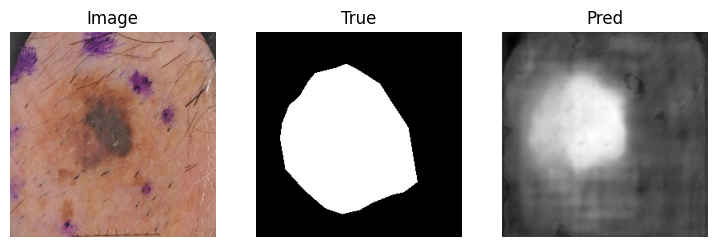

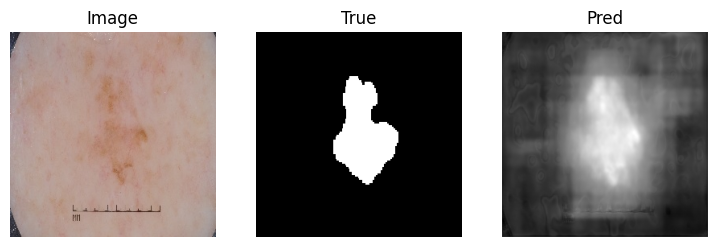

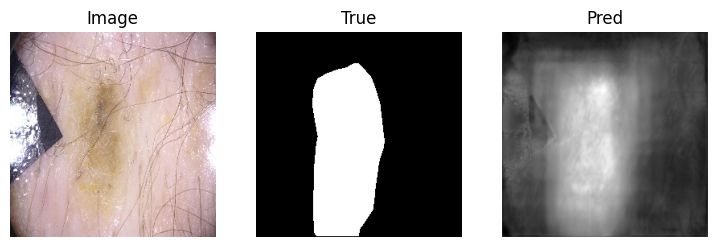

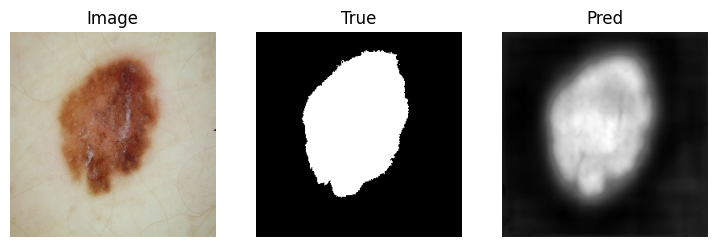

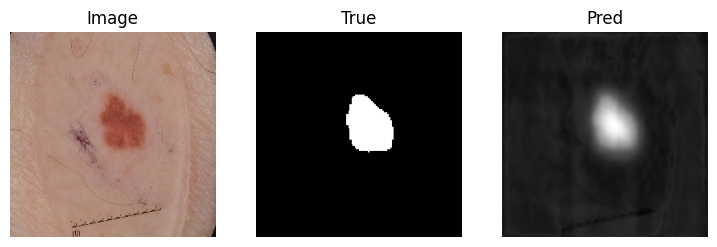

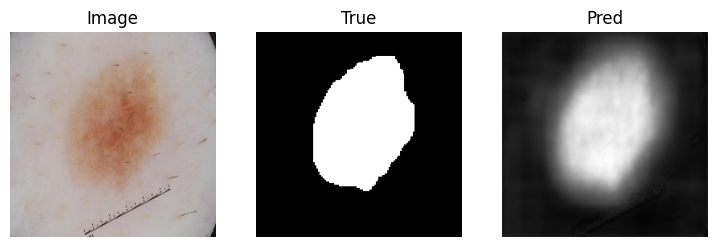

In [ ]:
# Load best model then visualize
ck = "/content/unet_best.pth"
ckd = torch.load(ck, map_location=device)
model.load_state_dict(ckd["model"])

import matplotlib.pyplot as plt
model.eval()
imgs, masks = next(iter(val_loader))
with torch.no_grad():
    preds = model(imgs.to(device)).cpu().numpy()

for i in range(min(6, imgs.shape[0])):
    im = np.transpose(imgs[i].numpy(), (1,2,0))
    m = masks[i].numpy()[0]
    p = preds[i][0]
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(im); plt.title("Image"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(m, cmap='gray'); plt.title("True"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(p, cmap='gray'); plt.title("Pred"); plt.axis('off')
    plt.show()

In [ ]:
# Save final checkpoint and manifests to working dir (downloadable)
torch.save(model.state_dict(), "/content/unet_final.pth")
print("Saved unet_final.pth")
!ls -lh /content/unet_best.pth /content/unet_final.pth
!head -n 5 /content/train_manifest.csv

Saved unet_final.pth
-rw-r--r-- 1 root root 356M Nov  5 16:09 /content/unet_best.pth
-rw-r--r-- 1 root root 119M Nov  5 16:39 /content/unet_final.pth
image,mask,stem
/content/data/resized/images/ISIC_0010226.jpg,/content/data/resized/masks/ISIC_0010226.png,ISIC_0010226
/content/data/resized/images/ISIC_0014506.jpg,/content/data/resized/masks/ISIC_0014506.png,ISIC_0014506
/content/data/resized/images/ISIC_0010069.jpg,/content/data/resized/masks/ISIC_0010069.png,ISIC_0010069
/content/data/resized/images/ISIC_0012682.jpg,/content/data/resized/masks/ISIC_0012682.png,ISIC_0012682


Pix2Pix


In [ ]:
# Dataset class for Pix2Pix (mask as input, image as target)
import torch
from torch.utils.data import Dataset, DataLoader
import cv2, numpy as np, albumentations as A
import pandas as pd

train_df = pd.read_csv("/content/train_manifest.csv")
val_df   = pd.read_csv("/content/val_manifest.csv")

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize()
])

class Pix2PixDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mask = cv2.imread(row["mask"], cv2.IMREAD_GRAYSCALE)
        img  = cv2.imread(row["image"]); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]
        mask = np.expand_dims(mask, 0).astype(np.float32)/255.0
        img  = np.transpose(img, (2,0,1)).astype(np.float32)/255.0
        return torch.tensor(mask), torch.tensor(img)

train_ds = Pix2PixDataset(train_df, transform)
val_ds   = Pix2PixDataset(val_df, A.Compose([A.Normalize()]))

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print("Pix2Pix train batches:", len(train_dl), "val batches:", len(val_dl))

Pix2Pix train batches: 260 val batches: 33


In [ ]:
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, features=64):
        super().__init__()
        self.enc = nn.ModuleList([
            self.down(in_ch, features, norm=False),
            self.down(features, features*2),
            self.down(features*2, features*4),
            self.down(features*4, features*8),
            self.down(features*8, features*8),
            self.down(features*8, features*8),
        ])
        self.dec = nn.ModuleList([
            self.up(features*8, features*8, dropout=True),
            self.up(features*16, features*8, dropout=True),
            self.up(features*16, features*4),
            self.up(features*8, features*2),
            self.up(features*4, features),
        ])
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def down(self, in_ch, out_ch, norm=True):
        layers = [nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False)]
        if norm: layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def up(self, in_ch, out_ch, dropout=False):
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]
        if dropout: layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        downs = []
        for layer in self.enc:
            x = layer(x)
            downs.append(x)
        x = downs[-1]
        ups = x
        for i, layer in enumerate(self.dec):
            ups = layer(ups)
            ups = torch.cat([ups, downs[-(i+2)]], dim=1)
        return self.final(ups)


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=4, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, features, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*2, features*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*4, 1, 4, 1, 1)
        )

    def forward(self, mask, img):
        x = torch.cat([mask, img], dim=1)
        return self.model(x)


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce = nn.BCEWithLogitsLoss()
l1  = nn.L1Loss()
lambda_L1 = 100

epochs = 200
for epoch in range(epochs):
    G.train(); D.train()
    loop = tqdm(train_dl, leave=False)
    g_loss_sum, d_loss_sum = 0, 0
    for mask, real_img in loop:
        mask, real_img = mask.to(device), real_img.to(device)

        # --- Train Discriminator ---
        fake_img = G(mask)
        D_real = D(mask, real_img)
        D_fake = D(mask, fake_img.detach())
        real_loss = bce(D_real, torch.ones_like(D_real))
        fake_loss = bce(D_fake, torch.zeros_like(D_fake))
        D_loss = (real_loss + fake_loss) * 0.5
        opt_D.zero_grad(); D_loss.backward(); opt_D.step()

        # --- Train Generator ---
        D_fake = D(mask, fake_img)
        G_adv = bce(D_fake, torch.ones_like(D_fake))
        G_L1  = l1(fake_img, real_img) * lambda_L1
        G_loss = G_adv + G_L1
        opt_G.zero_grad(); G_loss.backward(); opt_G.step()

        g_loss_sum += G_loss.item()
        d_loss_sum += D_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss_sum/len(train_dl):.4f}  G_loss: {g_loss_sum/len(train_dl):.4f}")


Epoch [1/200]  D_loss: 0.2853  G_loss: 7.6798


Epoch [2/200]  D_loss: 0.1039  G_loss: 5.8990


Epoch [3/200]  D_loss: 0.0232  G_loss: 7.3299


Epoch [4/200]  D_loss: 0.0444  G_loss: 7.2660


Epoch [5/200]  D_loss: 0.0232  G_loss: 7.3166


Epoch [6/200]  D_loss: 0.0226  G_loss: 7.5813


Epoch [7/200]  D_loss: 0.0038  G_loss: 8.4934


Epoch [8/200]  D_loss: 0.0027  G_loss: 8.8085


Epoch [9/200]  D_loss: 0.0315  G_loss: 8.1111


Epoch [10/200]  D_loss: 0.0025  G_loss: 8.6894


Epoch [11/200]  D_loss: 0.0021  G_loss: 9.3511


Epoch [12/200]  D_loss: 0.1502  G_loss: 5.7080


Epoch [13/200]  D_loss: 0.0427  G_loss: 6.4624


Epoch [14/200]  D_loss: 0.0208  G_loss: 7.1087


Epoch [15/200]  D_loss: 0.0369  G_loss: 6.6628


Epoch [16/200]  D_loss: 0.0035  G_loss: 8.3495


Epoch [17/200]  D_loss: 0.0015  G_loss: 8.4445


Epoch [18/200]  D_loss: 0.0014  G_loss: 9.5827


Epoch [19/200]  D_loss: 0.0004  G_loss: 10.8316


Epoch [20/200]  D_loss: 0.0007  G_loss: 10.6139


Epoch [21/200]  D_loss: 0.0960  G_loss: 9.3515


Epoch [22/200]  D_loss: 0.0686  G_loss: 5.3265


Epoch [23/200]  D_loss: 0.0032  G_loss: 7.6394


Epoch [24/200]  D_loss: 0.0211  G_loss: 8.3618


Epoch [25/200]  D_loss: 0.0035  G_loss: 8.1207


Epoch [26/200]  D_loss: 0.0011  G_loss: 9.3297


Epoch [27/200]  D_loss: 0.0008  G_loss: 9.6936


Epoch [28/200]  D_loss: 0.0007  G_loss: 10.4529


Epoch [29/200]  D_loss: 0.0005  G_loss: 11.0013


Epoch [30/200]  D_loss: 0.0003  G_loss: 10.7766


Epoch [31/200]  D_loss: 0.0002  G_loss: 11.4878


Epoch [32/200]  D_loss: 0.0002  G_loss: 11.7980


Epoch [33/200]  D_loss: 0.0001  G_loss: 11.0024


Epoch [34/200]  D_loss: 0.2158  G_loss: 5.2709


Epoch [35/200]  D_loss: 0.0094  G_loss: 6.6204


Epoch [36/200]  D_loss: 0.0042  G_loss: 8.6654


Epoch [37/200]  D_loss: 0.0795  G_loss: 8.3364


Epoch [38/200]  D_loss: 0.0406  G_loss: 9.1416


Epoch [39/200]  D_loss: 0.0400  G_loss: 9.4979


Epoch [40/200]  D_loss: 0.0039  G_loss: 10.2413


Epoch [41/200]  D_loss: 0.0018  G_loss: 10.9864


Epoch [42/200]  D_loss: 0.0011  G_loss: 10.2125


Epoch [43/200]  D_loss: 0.0009  G_loss: 10.6274


Epoch [44/200]  D_loss: 0.0007  G_loss: 10.9493


Epoch [45/200]  D_loss: 0.0007  G_loss: 11.9738


Epoch [46/200]  D_loss: 0.0001  G_loss: 10.5584


Epoch [47/200]  D_loss: 0.0001  G_loss: 10.9593


Epoch [48/200]  D_loss: 0.0003  G_loss: 10.1148


Epoch [49/200]  D_loss: 0.0004  G_loss: 9.6928


Epoch [50/200]  D_loss: 0.0003  G_loss: 10.1591


Epoch [51/200]  D_loss: 0.0002  G_loss: 10.7452


Epoch [52/200]  D_loss: 0.0001  G_loss: 11.0671


Epoch [53/200]  D_loss: 0.0001  G_loss: 11.2046


Epoch [54/200]  D_loss: 0.0001  G_loss: 11.4504


Epoch [55/200]  D_loss: 0.0001  G_loss: 11.9379


Epoch [56/200]  D_loss: 0.0001  G_loss: 12.2396


Epoch [57/200]  D_loss: 0.0001  G_loss: 12.4014


Epoch [58/200]  D_loss: 0.3878  G_loss: 6.0698


Epoch [59/200]  D_loss: 0.3667  G_loss: 3.0401


Epoch [60/200]  D_loss: 0.6179  G_loss: 1.4267


Epoch [61/200]  D_loss: 0.0939  G_loss: 6.1852


Epoch [62/200]  D_loss: 0.0317  G_loss: 8.3579


Epoch [63/200]  D_loss: 0.0250  G_loss: 8.0889


Epoch [64/200]  D_loss: 0.0043  G_loss: 9.0031


Epoch [65/200]  D_loss: 0.0167  G_loss: 9.4649


Epoch [66/200]  D_loss: 0.0030  G_loss: 9.6273


Epoch [67/200]  D_loss: 0.0021  G_loss: 10.4083


Epoch [68/200]  D_loss: 0.0012  G_loss: 11.4929


Epoch [69/200]  D_loss: 0.0014  G_loss: 11.6981


Epoch [70/200]  D_loss: 0.1165  G_loss: 11.4546


Epoch [71/200]  D_loss: 0.4548  G_loss: 2.6154


Epoch [72/200]  D_loss: 0.1125  G_loss: 5.5794


Epoch [73/200]  D_loss: 0.0304  G_loss: 6.8750


Epoch [74/200]  D_loss: 0.0081  G_loss: 8.6890


Epoch [75/200]  D_loss: 0.0024  G_loss: 8.7605


Epoch [76/200]  D_loss: 0.0017  G_loss: 9.3407


Epoch [77/200]  D_loss: 0.0016  G_loss: 9.8777


Epoch [78/200]  D_loss: 0.0025  G_loss: 11.4891


Epoch [79/200]  D_loss: 0.0902  G_loss: 7.9664


Epoch [80/200]  D_loss: 0.0126  G_loss: 9.7086


Epoch [81/200]  D_loss: 0.0100  G_loss: 9.2464


Epoch [82/200]  D_loss: 0.0013  G_loss: 8.3900


Epoch [83/200]  D_loss: 0.0015  G_loss: 8.5523


Epoch [84/200]  D_loss: 0.0009  G_loss: 9.8179


Epoch [85/200]  D_loss: 0.1781  G_loss: 9.1536


Epoch [86/200]  D_loss: 0.5617  G_loss: 1.9352


Epoch [87/200]  D_loss: 0.1923  G_loss: 5.5577


Epoch [88/200]  D_loss: 0.1200  G_loss: 6.3156


Epoch [89/200]  D_loss: 0.0501  G_loss: 8.0425


Epoch [90/200]  D_loss: 0.0524  G_loss: 8.1177


Epoch [91/200]  D_loss: 0.0071  G_loss: 10.0303


Epoch [92/200]  D_loss: 0.0202  G_loss: 9.3099


Epoch [93/200]  D_loss: 0.0047  G_loss: 10.8426


Epoch [94/200]  D_loss: 0.0816  G_loss: 10.7334


Epoch [95/200]  D_loss: 0.1295  G_loss: 8.4637


Epoch [96/200]  D_loss: 0.0498  G_loss: 8.8464


Epoch [97/200]  D_loss: 0.0124  G_loss: 10.3974


Epoch [98/200]  D_loss: 0.0035  G_loss: 10.7648


Epoch [99/200]  D_loss: 0.1047  G_loss: 9.4867


Epoch [100/200]  D_loss: 0.2151  G_loss: 5.7666


Epoch [101/200]  D_loss: 0.0118  G_loss: 10.5102


Epoch [102/200]  D_loss: 0.1674  G_loss: 7.6697


Epoch [103/200]  D_loss: 0.0838  G_loss: 7.3915


 91%|█████████ | 237/260 [00:50<00:04,  4.73it/s]

In [ ]:
import matplotlib.pyplot as plt
G.eval()
mask, real = next(iter(val_dl))
mask, real = mask.to(device), real.to(device)
with torch.no_grad():
    fake = G(mask)

for i in range(4):
    m = mask[i][0].cpu().numpy()
    r = np.transpose(real[i].cpu().numpy(), (1,2,0))
    f = np.transpose(fake[i].cpu().numpy(), (1,2,0))
    f = (f - f.min()) / (f.max()-f.min()+1e-8)
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(m, cmap='gray'); plt.title("Mask"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(r); plt.title("Real"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(f); plt.title("Generated"); plt.axis('off')
    plt.show()

NameError: name 'G' is not defined

In [ ]:
torch.save(G.state_dict(), "/content/pix2pix_gen.pth")
torch.save(D.state_dict(), "/content/pix2pix_disc.pth")
print("Saved pix2pix_gen.pth and pix2pix_disc.pth")
!ls -lh /content/pix2pix_gen.pth

NameError: name 'torch' is not defined

In [ ]:
# Install lpips if you want perceptual metric (optional, slower)
# !pip install -q lpips

import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

G.eval()
masks, reals = next(iter(val_dl))
masks = masks.to(device); reals = reals.to(device)
with torch.no_grad():
    fakes = G(masks).cpu().numpy()
reals_np = reals.cpu().numpy()

ssim_vals = []
psnr_vals = []
for i in range(fakes.shape[0]):
    fake = np.transpose(fakes[i], (1,2,0))
    real = np.transpose(reals_np[i], (1,2,0))
    # ensure in [-1,1] range for ssim and psnr
    fake = (fake - fake.min()) / (fake.max() - fake.min() + 1e-8) * 2 - 1
    real = real * 2 - 1
    s = ssim(real, fake, multichannel=True, data_range=2.0, win_size=3)
    p = psnr(real, fake, data_range=2.0)
    ssim_vals.append(s); psnr_vals.append(p)

print(f"SSIM (mean): {np.mean(ssim_vals):.4f}  PSNR (mean): {np.mean(psnr_vals):.2f} dB")
# Optional: LPIPS (uncomment to run)
# import lpips
# loss_fn = lpips.LPIPS(net='vgg').to(device)
# lpips_vals = []
# for i in range(fakes.shape[0]):
#     f = torch.tensor(np.transpose(fakes[i], (2,0,1))).unsqueeze(0).to(device)
#     r = torch.tensor(np.transpose(reals_np[i], (2,0,1))).unsqueeze(0).to(device)
#     lp = loss_fn(f*2-1, r*2-1)  # if lpips expects [-1,1]
#     lpips_vals.append(lp.item())
# print("LPIPS (mean):", np.mean(lpips_vals))

In [ ]:
# Simple temporal transforms on masks + images
import cv2, os
from glob import glob
SRC_IMG = "/content/data/resized/images"
SRC_MASK = "/content/data/resized/masks"
OUT_ROOT = "/content/data/temporal_pairs"
os.makedirs(OUT_ROOT, exist_ok=True)

def grow_mask(mask, percent):
    # mask uint8: 0/255
    h, w = mask.shape
    ksize = int(3 + percent*10)  # kernel size grows with percent
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    grown = cv2.dilate(mask, k, iterations=1)
    return grown

img_paths = sorted(glob(SRC_IMG + "/*.jpg"))
for p in img_paths[:2000]:   # generate for first 2000 for speed; remove slice to do all
    stem = os.path.splitext(os.path.basename(p))[0]
    mpath = os.path.join(SRC_MASK, stem + ".png")
    if not os.path.exists(mpath): continue
    img = cv2.imread(p); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
    # horizons and growth % (example)
    horizons = {"6m":0.08, "12m":0.18, "24m":0.30}
    for hname, pct in horizons.items():
        new_mask = grow_mask(mask, pct)
        # for visual realism: blend inside mask with slight darkening/texture change
        result = img.copy()
        # darken lesion area slightly
        mask_bool = new_mask>127
        result[mask_bool] = (result[mask_bool] * 0.9).astype(result.dtype)
        out_dir = os.path.join(OUT_ROOT, hname)
        os.makedirs(out_dir, exist_ok=True)
        cv2.imwrite(os.path.join(out_dir, stem + "_future.jpg"), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(out_dir, stem + "_future_mask.png"), new_mask)
print("Synthetic temporal pairs saved to:", OUT_ROOT)